In [141]:
import pickle
import sys
sys.path.append("../../spike")
import spike.multirecording_spikeanalysis as spike
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import sem
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import matplotlib.patches as mpatches
from itertools import combinations
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
import seaborn as sns
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titleweight'] = 'bold'

def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):   
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl 
    Returns:
        none
    """
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))
    
import spike.spike_analysis.firing_rate_calculations as fr
import spike.spike_analysis.spike_collection as collection
import spike.spike_analysis.spike_recording as recording

import spike.spike_analysis.pca_trajectories as pca_trajectories
import pickle


In [87]:
cagemate_collection = unpickle_this('cagemate_collection.pkl')
novel_collection = unpickle_this('novel_collection.pkl')


In [93]:
cagemate_collection.analyze(timebin = 100, ignore_freq=0.5, smoothing_window=500)
novel_collection.analyze(timebin = 100, ignore_freq=0.5, smoothing_window=500)

All set to analyze
All set to analyze


Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons


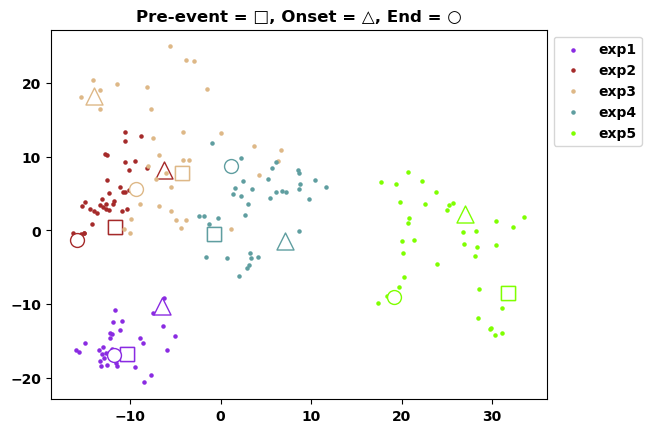

14


In [99]:
cagemate_pc_dict = pca_trajectories.avg_trajectories_pca(cagemate_collection, 3, 1, min_neurons=5, plot = True)
var = cagemate_pc_dict['explained variance']
total_var = 0
for i in range(len(cagemate_pc_dict['explained variance'])):
    total_var = total_var + cagemate_pc_dict['explained variance'][i]
    if total_var > .9:
        print(i)
        break

Excluding 33_nov_p1_merged.rec with 1 neurons


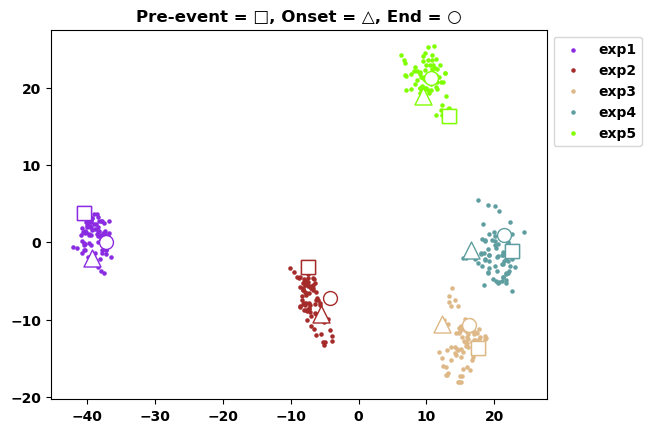

10


In [98]:
novel_pc_dict = pca_trajectories.avg_trajectories_pca(novel_collection, 5, 3, min_neurons=5, plot = True)
var = novel_pc_dict['explained variance']
total_var = 0
for i in range(len(novel_pc_dict['explained variance'])):
    total_var = total_var + novel_pc_dict['explained variance'][i]
    if total_var > .9:
        print(i)
        break

In [89]:
import importlib
importlib.reload(pca_trajectories)
cagemate_collection.analyze(timebin = 50, ignore_freq = 0.5)
geo_dist = pca_trajectories.avg_geo_dist(cagemate_collection, 3, 1, percent_var=90, post_window=0, min_neurons = 5)
geo_dist

All set to analyze
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons


,exp1_exp2,exp1_exp3,exp1_exp4,exp1_exp5,exp2_exp3,exp2_exp4,exp2_exp5,exp3_exp4,exp3_exp5,exp4_exp5
11_cage_p1_merged.rec,[1349.6476177798072],[1364.4002617884314],[1205.662694542783],[1715.4511939109022],[1668.5570853484924],[1366.3900186251715],[1892.344172084551],[1572.6106241238415],[2016.9953428408026],[1879.4532996731446]
12_cage_p1_merged.rec,[851.6033255867203],[743.6183595778766],[787.9995779757047],[712.8311048803796],[816.0465051298704],[789.7884082745785],[852.8548066088837],[694.668593034123],[760.4999396490728],[788.5367407800863]
13_cage_p1_merged.rec,[1401.4090321115464],[1239.088806175659],[1295.7686491268441],[1363.5011922259876],[1604.8174894370525],[1656.5551616282414],[1511.4902309632407],[1518.3331758310962],[1465.581002929201],[1587.9730317170852]
21_cage_p1_merged.rec,[1001.6463060703277],[1022.3960685851958],[940.6713126761603],[902.9613981750775],[1030.3393893281843],[1104.6332733788722],[1120.74934205838],[1094.7559536414994],[1091.3974016655598],[953.7434919577852]
22_cage_p1_merged.rec,[777.1674757078032],[1021.9827934605707],[1134.5408071960378],[1129.755585849193],[937.4016718897519],[1165.4726304339201],[1148.0441177240214],[1215.0097073771426],[1282.4576423953115],[1291.2210149623702]
24_cage_p1_merged.rec,[1704.629047388844],[2272.078599020619],[1785.510338040395],[2000.28289328641],[1801.1949675381932],[1579.438748682122],[1779.520272892416],[1851.112210464922],[2124.2438083149063],[1721.5717514746316]
32_cage_p1_merged.rec,[1380.5672765559366],[1673.8152230657884],[1508.7150519116453],[1525.0082344865498],[1731.2291106535884],[1595.4007200061774],[1556.3160693394937],[1799.4943787502657],[1786.7326961187343],[1372.5873985549242]
41_cage_p1_merged.rec,[795.6240990726142],[922.1580126788047],[856.1633260501243],[1106.115871566443],[893.1673978306776],[871.1894652874039],[1139.8636185707321],[935.6033520852782],[1055.574405031397],[957.7182629743376]
44_cage_p1_merged.rec,[2200.2609717833006],[2817.209150495859],[2912.319172257859],[3120.7073701191316],[2567.889387707439],[2837.3930992759415],[3131.444723921219],[3159.780293745947],[3396.868725182396],[3325.2863211269705]


In [122]:
from importlib import reload
reload(pca_trajectories)
novel_collection.analyze(timebin = 100, ignore_freq = 0.5, smoothing_window=500)
geo_dist = pca_trajectories.avg_geo_dist(novel_collection, events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'], event_length=3, pre_window=1, percent_var=90, post_window=0, min_neurons = 5)
avg_vals_df = geo_dist.mean()
avg_vals = avg_vals_df.values.tolist()
avg_sems = geo_dist.sem()
avg_sems = avg_sems.values.tolist()
geo_dist


All set to analyze
Excluding 33_nov_p1_merged.rec with 1 neurons


,exp1_exp2,exp1_exp3,exp1_exp4,exp1_exp5,exp2_exp3,exp2_exp4,exp2_exp5,exp3_exp4,exp3_exp5,exp4_exp5
11_nov_p1_merged.rec,573.980349,755.266514,805.074686,631.309873,289.624179,388.510733,333.524078,254.604408,308.017281,316.569582
12_nov_p1_merged.rec,197.885621,323.731092,381.614667,209.759302,297.419210,349.295425,227.013933,299.507563,344.657092,418.574059
13_nov_p1_merged.rec,653.761568,669.421546,501.885905,588.610834,141.056326,312.874998,457.737247,317.714019,463.924420,273.920535
21_nov_p1_merged.rec,203.891653,375.209056,397.132839,449.363507,312.327362,361.356549,414.456098,301.475269,309.442452,298.436820
22_nov_p1_merged.rec,377.724877,426.456720,441.522036,327.732036,269.166104,325.821729,356.730095,218.043746,276.117959,222.431902
24_nov_p1_merged.rec,437.989190,448.783647,501.882231,425.911089,333.858683,316.236509,538.174009,399.761963,527.350373,553.849636
32_nov_p1_merged.rec,392.144920,487.623089,470.658999,382.977318,382.773552,358.321054,499.187793,276.074672,564.490143,521.443448
41_nov_p1_merged.rec,806.055389,1275.430448,1552.931940,1555.655509,620.311388,838.932139,899.372285,433.968426,589.141309,474.651839
44_nov_p1_merged.rec,719.900006,1380.677757,1377.561188,1067.551324,776.197000,736.922037,709.164992,473.787307,963.569638,786.604125


In [139]:
novel_geo_dist = pca_trajectories.avg_geo_dist(novel_collection, events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'], event_length=3, pre_window=1, percent_var=90, post_window=0, min_neurons = 5)
novel_geo_dist
avg_vals_df = novel_geo_dist.mean()
avg_vals_df

Excluding 33_nov_p1_merged.rec with 1 neurons


exp1_exp2    484.814842
exp1_exp3    682.511096
exp1_exp4    714.473832
exp1_exp5    626.541199
exp2_exp3    380.303756
exp2_exp4    443.141241
exp2_exp5    492.817837
exp3_exp4    330.548597
exp3_exp5    482.967852
exp4_exp5    429.609105
dtype: float64

In [153]:
def create_comparison_matrix(df):
    # Get unique experiments
    experiments = sorted(list(set([exp for col in df.columns for exp in col.split('_')])))
    n = len(experiments)
    
    # Create empty matrix
    matrix = np.zeros((n, n))
    
    # Fill matrix
    for i, exp1 in enumerate(experiments):
        for j, exp2 in enumerate(experiments):
            if i == j:
                matrix[i,j] = 1
            else:
                col1 = f"{exp1}_{exp2}"
                col2 = f"{exp2}_{exp1}"
                if col1 in df.columns:
                    matrix[i,j] = df[col1].mean()
                elif col2 in df.columns:
                    matrix[i,j] = df[col2].mean()
    
    return pd.DataFrame(matrix, index=experiments, columns=experiments)

def plot_comparison_heatmap(df, title):
    # Create comparison matrix
    matrix = create_comparison_matrix(df)
    
    # Create figure
    plt.figure(figsize=(5, 4))
    
    # Create heatmap
    sns.heatmap(matrix, 
                annot=True, 
                cmap='Blues',
                fmt='.3f',
                square=True,
                cbar_kws={'label': 'AU Distance'})
    
    plt.title(title)
    plt.tight_layout()
    return plt



<module 'matplotlib.pyplot' from 'c:\\Users\\megha\\anaconda3\\envs\\lfp_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

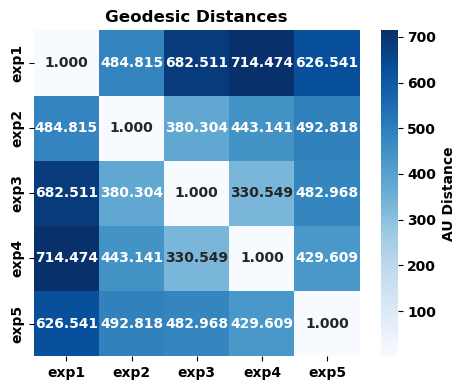

In [148]:
plot_comparison_heatmap(novel_geo_dist)

In [137]:
avg_vals = np.array(avg_vals_df.values.tolist())
avg_vals = avg_vals[[2, 3, 9]]
avg_sems = geo_dist.sem()

avg_sems = np.array(avg_sems.values.tolist())
avg_sems = avg_sems[[2,3,9]]

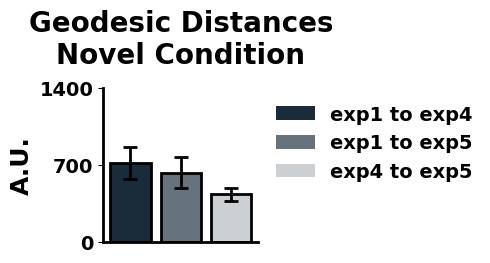

In [138]:

color_id_dict = {'exp1 to exp4': hex_2_rgb('#1a2c3a'),  
                'exp1 to exp5': hex_2_rgb('#66727c'),
                'exp4 to exp5': hex_2_rgb('#ccd0d3')
                }
hatches = ['','','']  
plt.figure(figsize= (2,2))           
plt.bar(color_id_dict.keys(), avg_vals, yerr = avg_sems,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black'],
            capsize = 5, linewidth = 2, error_kw={'elinewidth': 2, 'capthick': 2})
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(700))
plt.ylim(0,1400)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
hatches = ['//','','','', '']
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Geodesic Distances\nNovel Condition', fontsize = 20, y =1.1)
plt.show()

In [150]:
geo_dist = pca_trajectories.avg_geo_dist(cagemate_collection, events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'], event_length=3, pre_window=1, percent_var=90, post_window=0, min_neurons = 5)
geo_dist
avg_vals_df = geo_dist.mean()
avg_vals_df

Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons


exp1_exp2    373.577302
exp1_exp3    417.757483
exp1_exp4    420.095260
exp1_exp5    512.890569
exp2_exp3    366.683120
exp2_exp4    414.865532
exp2_exp5    527.373393
exp3_exp4    407.207632
exp3_exp5    512.568880
exp4_exp5    448.558863
dtype: float64

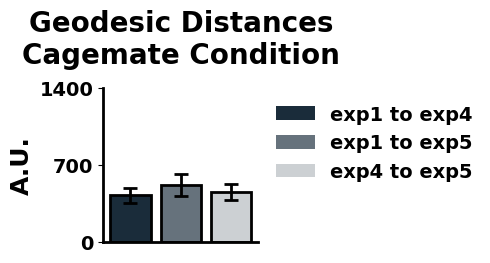

In [151]:
avg_vals = np.array(avg_vals_df.values.tolist())
avg_vals = avg_vals[[2, 3, 9]]
avg_sems = geo_dist.sem()

avg_sems = np.array(avg_sems.values.tolist())
avg_sems = avg_sems[[2,3,9]]
color_id_dict = {'exp1 to exp4': hex_2_rgb('#1a2c3a'),  
                'exp1 to exp5': hex_2_rgb('#66727c'),
                'exp4 to exp5': hex_2_rgb('#ccd0d3')
                }
hatches = ['','','']  
plt.figure(figsize= (2,2))           
plt.bar(color_id_dict.keys(), avg_vals, yerr = avg_sems,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black'],
            capsize = 5, linewidth = 2, error_kw={'elinewidth': 2, 'capthick': 2})
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(700))
plt.ylim(0,1400)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
hatches = ['//','','','', '']
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Geodesic Distances\nCagemate Condition', fontsize = 20, y =1.1)
plt.show()

<module 'matplotlib.pyplot' from 'c:\\Users\\megha\\anaconda3\\envs\\lfp_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

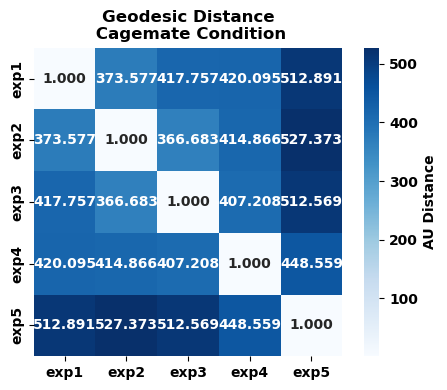

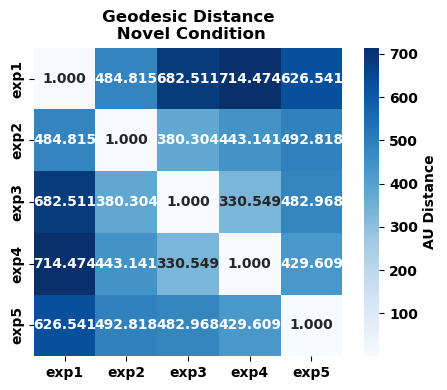

In [155]:
plot_comparison_heatmap(geo_dist, title = "Geodesic Distance\n Cagemate Condition")
plot_comparison_heatmap(novel_geo_dist, title = "Geodesic Distance\n Novel Condition")

In [162]:

dimensionality = []
for recording in novel_collection.collection:
    pca_trajectories.avg_trajectories_pca(recording, events = ['exp1', 'exp5'], event_length=5, pre_window = 3, min_neurons=5, plot = False)
    total_var = 0
    for i in range(len(novel_pc_dict['explained variance'])):
        total_var = total_var + novel_pc_dict['explained variance'][i]
        if total_var > .9:
            dimensionality.append(i)
            break
            

print(np.mean(np.array(dimensionality)))

Excluding 33_nov_p1_merged.rec with 1 neurons
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
4.0


In [178]:
dimensionality = []
for recording in novel_collection.collection:
    novel_pc_dict = pca_trajectories.avg_trajectories_pca(recording, events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'], event_length=3, pre_window = 1, min_neurons=5, plot = False)
    total_var = 0
    if novel_pc_dict:
        for i in range(len(novel_pc_dict['explained variance'])):
            total_var = total_var + novel_pc_dict['explained variance'][i]
            if total_var > .9:
                dimensionality.append(i)
                break
            

print(np.mean(np.array(dimensionality)))

Excluding 33_nov_p1_merged.rec with 1 neurons
2.888888888888889


Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons


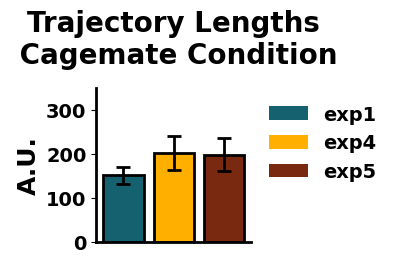

,Comparison,t_statistic,p_value,p_adjusted,significant
0,exp1_exp4,-2.239880,0.055436,0.166308,False
1,exp1_exp5,-2.012005,0.079032,0.166308,False
2,exp4_exp5,0.211018,0.838149,0.838149,False


In [197]:
from scipy.spatial.distance import euclidean
from statsmodels.stats.multitest import multipletests
def trajectory_length(pca_matrix, key):
    trajectory_lengths = []
    event_order = []
    unique_values, counts = np.unique(key, return_counts=True)
    event_len = counts[0]
    for j in range(0, len(key), event_len):
        trajectory_length = 0
        for i in range(event_len-1):
            trajectory_length = trajectory_length + euclidean(
                pca_matrix[j+i, :],
                pca_matrix[j+i+1, :])
        trajectory_lengths.append(trajectory_length)
        event_order.append(key[j])
    return [trajectory_lengths, event_order]

trajectory_lengths = []
orders= []
for recording in cagemate_collection.collection:
    pc_dict = pca_trajectories.avg_trajectories_pca(recording, event_length = 5, pre_window = 3,
                                                 events = ['exp1',
                                                           'exp4',
                                                           'exp5'], min_neurons=5, plot = False)
    if pc_dict:
        [traj_len, event_order] = trajectory_length(pc_dict['transformed data'],
                                                pc_dict['labels'])
        trajectory_lengths.append(traj_len)
        orders.append(event_order)
trajectory_lengths = np.array(trajectory_lengths)



means = np.mean(trajectory_lengths, axis = 0)
sems = sem(trajectory_lengths, axis = 0)

t_exp1_exp4, p_exp1_exp4 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,1])
t_exp1_exp5, p_exp1_exp5 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,2])
t_exp4_exp5, p_exp4_exp5 = stats.ttest_rel(trajectory_lengths[:,1], trajectory_lengths[:,2])
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
stats_df = pd.DataFrame({
   'Comparison': ['exp1_exp4', 'exp1_exp5', 'exp4_exp5'],
   't_statistic': [t_exp1_exp4, t_exp1_exp5, t_exp4_exp5],
   'p_value': p_values,
   'p_adjusted': p_adjusted,
   'significant': reject
})

# Adjust p-values using Holm-Bonferroni
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
color_id_dict = {'exp1': hex_2_rgb('#15616F'), 
                'exp4': (1.0, 0.6862745098039216, 0.0),
                  'exp5': hex_2_rgb('#792910')}
hatches = ['','','']  
x = [0.5,1,1.5]
plt.figure(figsize= (2,2))           
plt.bar(x, means, yerr = sems,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black'],
            capsize = 5, linewidth = 2,
            error_kw={'elinewidth': 2, 'capthick': 2}, 
            width = .4)
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.ylim(0,350)
hatches = ['//','','','', '']
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Trajectory Lengths\n Cagemate Condition', fontsize = 20, y = 1.1)
plt.show()

stats_df


Excluding 33_nov_p1_merged.rec with 1 neurons


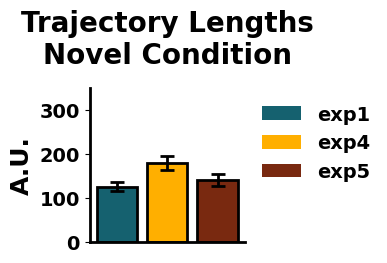

,Comparison,t_statistic,p_value,p_adjusted,significant
0,exp1_exp4,-3.150543,0.013587,0.040762,True
1,exp1_exp5,-1.698072,0.127926,0.127926,False
2,exp4_exp5,2.973538,0.017775,0.040762,True


In [199]:

def trajectory_length(pca_matrix, key):
    trajectory_lengths = []
    event_order = []
    unique_values, counts = np.unique(key, return_counts=True)
    event_len = counts[0]
    for j in range(0, len(key), event_len):
        trajectory_length = 0
        for i in range(event_len-1):
            trajectory_length = trajectory_length + euclidean(
                pca_matrix[j+i, :],
                pca_matrix[j+i+1, :])
        trajectory_lengths.append(trajectory_length)
        event_order.append(key[j])
    return [trajectory_lengths, event_order]

trajectory_lengths = []
orders= []
for recording in novel_collection.collection:
    pc_dict = pca_trajectories.avg_trajectories_pca(recording, event_length = 5, pre_window = 3,
                                                 events = ['exp1',
                                                           'exp4',
                                                           'exp5'], min_neurons=5, plot = False)
    if pc_dict:
        [traj_len, event_order] = trajectory_length(pc_dict['transformed data'],
                                                pc_dict['labels'])
        trajectory_lengths.append(traj_len)
        orders.append(event_order)
trajectory_lengths = np.array(trajectory_lengths)


means = np.mean(trajectory_lengths, axis = 0)
sems = sem(trajectory_lengths, axis = 0)
t_exp1_exp4, p_exp1_exp4 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,1])
t_exp1_exp5, p_exp1_exp5 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,2])
t_exp4_exp5, p_exp4_exp5 = stats.ttest_rel(trajectory_lengths[:,1], trajectory_lengths[:,2])

# Adjust p-values using Holm-Bonferroni
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')

# Create DataFrame
stats_df = pd.DataFrame({
   'Comparison': ['exp1_exp4', 'exp1_exp5', 'exp4_exp5'],
   't_statistic': [t_exp1_exp4, t_exp1_exp5, t_exp4_exp5],
   'p_value': p_values,
   'p_adjusted': p_adjusted,
   'significant': reject
})

color_id_dict = {'exp1': hex_2_rgb('#15616F'), 
                'exp4': (1.0, 0.6862745098039216, 0.0),
                  'exp5': hex_2_rgb('#792910')}
hatches = ['','','']  
x = [0.5,1,1.5]
plt.figure(figsize= (2,2))           
plt.bar(x, means, yerr = sems,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black'],
            capsize = 5, linewidth = 2,
            error_kw={'elinewidth': 2, 'capthick': 2}, 
            width = .4)
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.ylim(0,350)
hatches = ['//','','','', '']
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Trajectory Lengths\nNovel Condition', fontsize = 20, y = 1.1)
plt.show()

stats_df

In [179]:

dimensionality = []
for recording in cagemate_collection.collection:
    cagemate_pc_dict = pca_trajectories.avg_trajectories_pca(recording, events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'], event_length=3, pre_window = 1, min_neurons=5, plot = False)
    total_var = 0
    if cagemate_pc_dict:
        for i in range(len(cagemate_pc_dict['explained variance'])):
            total_var = total_var + cagemate_pc_dict['explained variance'][i]
            if total_var > .9:
                dimensionality.append(i)
                break
            

print(np.mean(np.array(dimensionality)))

Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
4.222222222222222


Excluding 33_nov_p1_merged.rec with 1 neurons


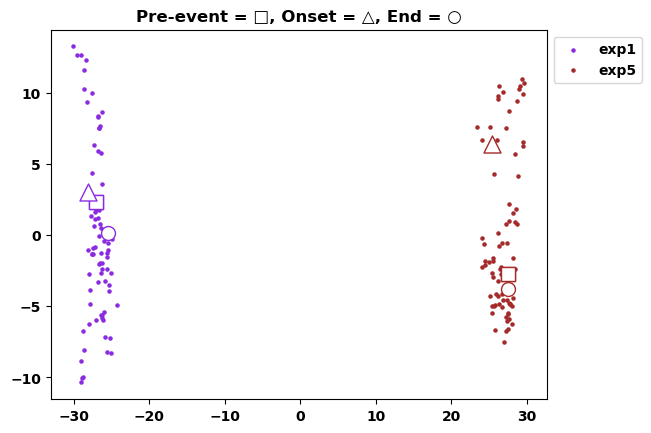

3


In [103]:
novel_pc_dict = pca_trajectories.avg_trajectories_pca(novel_collection, events = ['exp1', 'exp5'], event_length=5, pre_window = 3, min_neurons=5, plot = True)
var = novel_pc_dict['explained variance']
total_var = 0
for i in range(len(novel_pc_dict['explained variance'])):
    total_var = total_var + novel_pc_dict['explained variance'][i]
    if total_var > .9:
        print(i)
        break

In [106]:
for recording in novel_collection.collection:
    novel = np.concatenate([recording.event_dict['exp1'], recording.event_dict['exp5']], axis = 0)
    recording.event_dict['novel'] = novel
    not_novel = np.concatenate([recording.event_dict['exp3'], recording.event_dict['exp4']], axis = 0)
    recording.event_dict['not_novel'] = not_novel
for recording in cagemate_collection.collection:
    novel = np.concatenate([recording.event_dict['exp1'], recording.event_dict['exp5']], axis = 0)
    recording.event_dict['novel'] = novel
    not_novel = np.concatenate([recording.event_dict['exp3'], recording.event_dict['exp4']], axis = 0)
    recording.event_dict['not_novel'] = not_novel

Excluding 33_nov_p1_merged.rec with 1 neurons


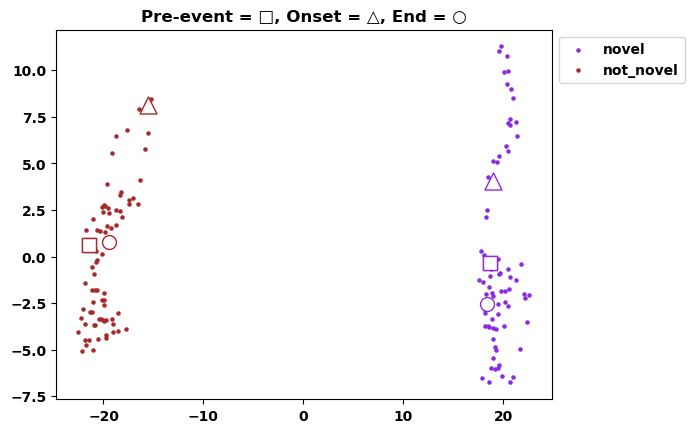

4


In [108]:
novel_pc_dict = pca_trajectories.avg_trajectories_pca(novel_collection, events = ['novel', 'not_novel'], event_length=5, pre_window = 3, min_neurons=5, plot = True)
var = novel_pc_dict['explained variance']
total_var = 0
for i in range(len(novel_pc_dict['explained variance'])):
    total_var = total_var + novel_pc_dict['explained variance'][i]
    if total_var > .9:
        print(i)
        break

Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons


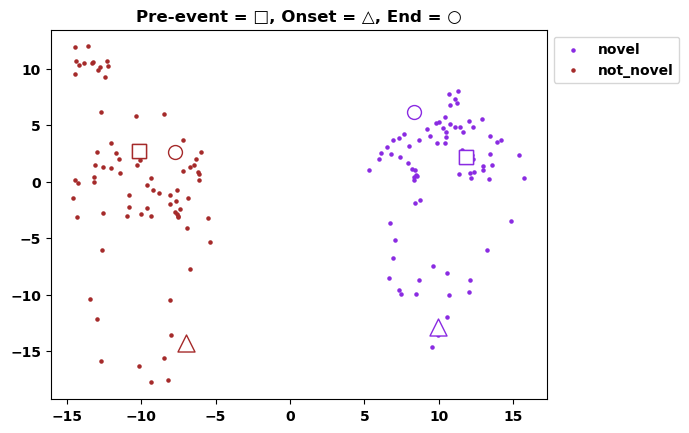

13


In [200]:
cagemate_pc_dict = pca_trajectories.avg_trajectories_pca(cagemate_collection, events = ['novel', 'not_novel'], event_length=5, pre_window = 3, min_neurons=5, plot = True)
var = cagemate_pc_dict['explained variance']
total_var = 0
for i in range(len(cagemate_pc_dict['explained variance'])):
    total_var = total_var + cagemate_pc_dict['explained variance'][i]
    if total_var > .9:
        print(i)
        break